In [24]:
from datetime import date
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import matplotlib.animation as animation
warnings.filterwarnings('ignore')
from src.data_processing.fetch_data import fetch_data_subgraph
from src.models.liquidity_distribution import UniswapV3LiquidityCalculator, LiquidityAnalyzer, Pool
pd.set_option("display.max_columns",100)
%load_ext autoreload
%autoreload 2

POOLS = [
    (3, "0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8", "v3 USDC/ETH 0.3%", ),
    (3, "0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640", "v3 USDC/ETH 0.05%", ),
]
API_KEY = "893d7471304c5edf436c8ba60781762c"
POOL_ADDRESS = "0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640".lower()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
pool_query = """query get_pools($pool_id: ID!) {
  pools(where: {id: $pool_id}) {
    tick
    sqrtPrice
    liquidity
    feeTier
    totalValueLockedUSD
    totalValueLockedETH
    token0 {
      symbol
      decimals
    }
    token1 {
      symbol
      decimals
    }
  }
}"""
# POOL_ADDRESS = "0xc7bBeC68d12a0d1830360F8Ec58fA599bA1b0e9b".lower()
variables = {'pool_id': POOL_ADDRESS}
data_pool = fetch_data_subgraph(API_KEY, pool_query, variables, data_key='pools', first_n=100, batch_size=1000)[0]

Fetched 1 records


In [19]:
data_pool

{'feeTier': '500',
 'liquidity': '7846212593929739997',
 'sqrtPrice': '1569823652220261569091699500093933',
 'tick': '197892',
 'token0': {'decimals': '6', 'symbol': 'USDC'},
 'token1': {'decimals': '18', 'symbol': 'WETH'},
 'totalValueLockedETH': '161711.0547747597277057290160247812',
 'totalValueLockedUSD': '412149384.1580930248408272318158348'}

In [20]:
# data = fetch_oku_liquidity(pool_address=POOL_ADDRESS, block_number=20719648)

In [39]:
START_DATE = date(2024, 1, 1)
END_DATE = date(2024, 7, 1)
pool = Pool(pool_address=POOL_ADDRESS,
            token0=data_pool['token0']['symbol'],
            token1=data_pool['token1']['symbol'],
            decimals0=data_pool['token0']['decimals'],
            decimals1=data_pool['token1']['decimals'],
            fee_tier=data_pool['feeTier'],
            sqrt_price_x96=data_pool["sqrtPrice"])

analyzer = LiquidityAnalyzer(
    pool,
    start_date=START_DATE,
    end_date=END_DATE,
    threshold_dollar_volume_swaps=20000000
)

Loading liquidity for block number 18909995
Loading liquidity for block number 18911563
Loading liquidity for block number 18912951
Loading liquidity for block number 18913979
Loading liquidity for block number 18914758
Loading liquidity for block number 18915118
Loading liquidity for block number 18915921
Loading liquidity for block number 18916179
Loading liquidity for block number 18916530
Loading liquidity for block number 18917177
Loading liquidity for block number 18917970
Loading liquidity for block number 18918719
Loading liquidity for block number 18919672
Loading liquidity for block number 18920396
Loading liquidity for block number 18920664
Loading liquidity for block number 18921197
Loading liquidity for block number 18921826
Loading liquidity for block number 18922278
Loading liquidity for block number 18923089
Loading liquidity for block number 18923952
Loading liquidity for block number 18925628
Loading liquidity for block number 18926513
Loading liquidity for block numb

In [ ]:
# liquidity.groupby(by='datetime')['amount_locked'].sum().plot()
# liquidity.groupby(by='datetime')['active_price_inverted'].min().plot()

In [42]:
def subselect_active_liquidity(nr_tick_around):
       analyzer.df_liquidity.columns = ['block', 'active_tick', 'tick', 'liquidity', 'price', 'amount0',
              'amount1', 'amount0_real', 'amount1_real']
       liquidity = pd.merge(analyzer.sampled_blocks,
              analyzer.df_liquidity,
              left_on='block_number',
              right_on='block')
       liquidity['active_tick_adjusted'] = np.floor(liquidity['active_tick'] / pool.tick_spacing) * pool.tick_spacing
       liquidity['sb'] = liquidity['tick']-pool.tick_spacing*nr_tick_around
       liquidity['sa'] = liquidity['tick']+pool.tick_spacing*nr_tick_around
       liquidity.loc[liquidity['tick']<liquidity['active_tick_adjusted'],'amount0_real'] = 0
       liquidity.loc[liquidity['tick']>liquidity['active_tick_adjusted'],'amount1_real'] = 0
       liquidity['active_price'] = np.float64(liquidity['active_tick'].apply(lambda x: pool.adjust_price(pool.tick_to_price(x))))
       liquidity['active_price_inverted'] = 1/liquidity['active_price']
       liquidity['amount_locked'] = liquidity['amount1_real']*liquidity['active_price_inverted'] + liquidity['amount0_real']
       active_liquidity = liquidity[(liquidity['active_tick_adjusted'] >= liquidity['sb']) & (liquidity['active_tick_adjusted'] <= liquidity['sa'])]
       active_liquidity = active_liquidity.reset_index(drop=True)
       return active_liquidity, liquidity

active_liquidity, liquidity = subselect_active_liquidity(3)
active_liquidity['amount_locked_USDC'] = active_liquidity.groupby(by='block_number')['amount_locked'].transform('sum')
active_liquidity_trading = active_liquidity[['datetime','block_number','active_tick_adjusted','active_price_inverted','cumulative_dollar_volume','amount_locked_USDC']].drop_duplicates()
active_liquidity_trading['trading_volume'] = active_liquidity_trading['cumulative_dollar_volume'] - active_liquidity_trading['cumulative_dollar_volume'].shift()
active_liquidity_trading['trading_fees'] = active_liquidity_trading['trading_volume'] * (pool.fee_tier / 1e6)
active_liquidity_trading['ROI_pool'] = active_liquidity_trading['trading_fees']/active_liquidity_trading['amount_locked_USDC']
active_liquidity_trading['date'] = active_liquidity_trading['datetime'].dt.normalize() 

In [59]:
# Example usage
amount0 = 10
amount1 = 2000
current_price = 2000
lower_price = 1500
upper_price = 2700

calculator = UniswapV3LiquidityCalculator(pool)
liquidity_provided = calculator.calculate_liquidity_with_tick_spacing(amount0, amount1, current_price, lower_price, upper_price)

In [61]:
#why is this not increasing way more with increased funds?!

In [62]:
liquidity_provided

334

In [ ]:
liquidity = pd.merge(analyzer.sampled_blocks,
              analyzer.df_liquidity,
              left_on='block_number',
              right_on='block')
#removing outliers
liquidity = liquidity.loc[liquidity['amount_locked']<50000000]

In [ ]:
class Position:
    def __init__(self, lower_tick: int, upper_tick: int, capital: float):
        self.lower_tick = lower_tick
        self.upper_tick = upper_tick
        self.capital = capital
        self.initial_capital = capital

    def is_in_range(self, current_tick: int) -> bool:
        return self.lower_tick <= current_tick <= self.upper_tick

    def update_value(self, current_price: float):
        # Simplified value update, doesn't account for impermanent loss
        self.capital *= current_price / self.initial_price
        self.initial_price = current_price

def should_rebalance(position: Position, current_tick: int, buffer: int = 20) -> bool:
    return (current_tick < position.lower_tick + buffer or 
            current_tick > position.upper_tick - buffer)

def calculate_fees(current_block: pd.Series, position: Position, total_liquidity: float) -> float:
    volume = current_block['cumulative_dollar_volume']
    fee_rate = pool.fee_tier / 1e6
    total_fees = volume * fee_rate
    liquidity_share = position.capital / total_liquidity
    return total_fees * liquidity_share

def calc_active_tvl(liquidity: pd.DataFrame, current_block: int, next_block: int, tick_range: int) -> float:
    current_data = liquidity[liquidity['block_number'] == current_block]
    next_data = liquidity[liquidity['block_number'] == next_block]
    
    if current_data.empty or next_data.empty:
        raise ValueError(f"No data for blocks {current_block} or {next_block}")
    
    tick_t = current_data['active_tick'].iloc[0]
    tick_t_1 = next_data['active_tick'].iloc[0]
    tick_difference = abs(tick_t_1 - tick_t)
    active_tick = current_data['active_tick_adjusted'].iloc[0]
    
    tvl_current_block = current_data[
        (current_data['tick'] >= (active_tick - tick_difference)) &
        (current_data['tick'] <= (active_tick + tick_difference))
    ]['amount_locked'].sum()
    
    return tvl_current_block

def backtest_liquidity_provision(liquidity: pd.DataFrame, initial_capital: float, tick_range: int, rebalance_cost: float) -> pd.DataFrame:
    results = []
    position = None
    hodl_capital = initial_capital

    blocks = liquidity['block_number'].unique()

    for i in range(len(blocks) - 1):
        current_block = blocks[i]
        next_block = blocks[i + 1]
        
        try:
            current_data = liquidity[liquidity['block_number'] == current_block].iloc[0]
            current_tick = current_data['active_tick_adjusted']
            current_price = current_data['price']

            if position is None:
                position = Position(current_tick - tick_range, current_tick + tick_range, initial_capital)
                position.initial_price = current_price

            active_tvl = calc_active_tvl(liquidity, current_block, next_block, tick_range)
            fees_earned = calculate_fees(current_data, position, active_tvl)
            position.capital += fees_earned

            rebalanced = False
            if should_rebalance(position, current_tick):
                rebalance_fee = position.capital * rebalance_cost
                position.capital -= rebalance_fee
                position = Position(current_tick - tick_range, current_tick + tick_range, position.capital)
                rebalanced = True

            position.update_value(current_price)
            
            # Update hodl capital
            hodl_capital *= current_price / liquidity[liquidity['block_number'] == blocks[0]]['price'].iloc[0]

            results.append({
                'block': current_block,
                'datetime': current_data['datetime'],
                'price': current_price,
                'position_capital': position.capital,
                'hodl_capital': hodl_capital,
                'fees_earned': fees_earned,
                'rebalanced': rebalanced
            })

        except Exception as e:
            print(f"Error at block {current_block}: {str(e)}")
            continue

    return pd.DataFrame(results)

# Run the backtest
initial_capital = 100000
tick_range = 200
rebalance_cost = 0.001

results_df = backtest_liquidity_provision(active_liquidity_trading, initial_capital, tick_range, rebalance_cost)

# Analyze results
results_df['lp_returns'] = results_df['position_capital'].pct_change()
results_df['hodl_returns'] = results_df['hodl_capital'].pct_change()

lp_cumulative_returns = (1 + results_df['lp_returns']).cumprod() - 1
hodl_cumulative_returns = (1 + results_df['hodl_returns']).cumprod() - 1

lp_sharpe_ratio = np.sqrt(365) * results_df['lp_returns'].mean() / results_df['lp_returns'].std()
hodl_sharpe_ratio = np.sqrt(365) * results_df['hodl_returns'].mean() / results_df['hodl_returns'].std()

print(f"LP Strategy Total Return: {lp_cumulative_returns.iloc[-1]:.2%}")
print(f"LP Strategy Sharpe Ratio: {lp_sharpe_ratio:.2f}")
print(f"HODL Strategy Total Return: {hodl_cumulative_returns.iloc[-1]:.2%}")
print(f"HODL Strategy Sharpe Ratio: {hodl_sharpe_ratio:.2f}")

# Plot results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(results_df['datetime'], results_df['position_capital'], label='LP Strategy')
plt.plot(results_df['datetime'], results_df['hodl_capital'], label='HODL Strategy')
plt.title('Liquidity Provision vs HODL Strategy Performance')
plt.xlabel('Date')
plt.ylabel('Capital')
plt.legend()
plt.show()

In [44]:
block = liquidity.loc[liquidity['block_number']==18909995]

<Axes: >

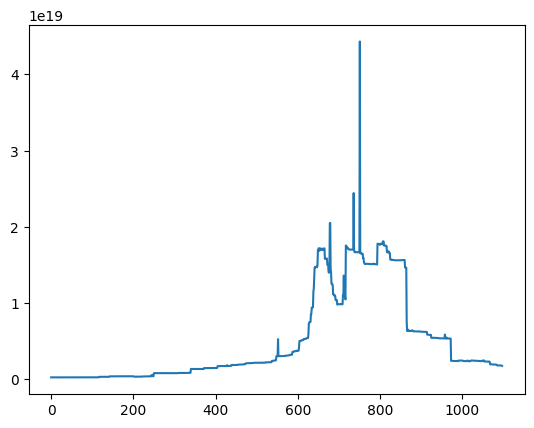

In [45]:
block.liquidity.plot()

In [43]:
liquidity

,block_number,block_timestamp,cumulative_dollar_volume,date,datetime,block,active_tick,tick,liquidity,price,amount0,amount1,amount0_real,amount1_real,active_tick_adjusted,sb,sa,active_price,active_price_inverted,amount_locked
0,18909995,1704080591,2.002804e+07,2024-01-01,2024-01-01 03:43:11,18909995,199011,192210,2.658259e+17,4496.174045,8.909607e+09,1.982588e+18,0.000000,1.982588,199010.0,192180,192240,0.000439,2277.687846,4515.717620
1,18909995,1704080591,2.002804e+07,2024-01-01,2024-01-01 03:43:11,18909995,199011,192220,2.658259e+17,4491.680343,8.905154e+09,1.983580e+18,0.000000,1.983580,199010.0,192190,192250,0.000439,2277.687846,4517.975931
2,18909995,1704080591,2.002804e+07,2024-01-01,2024-01-01 03:43:11,18909995,199011,192230,2.658259e+17,4487.191132,8.900702e+09,1.984572e+18,0.000000,1.984572,199010.0,192200,192260,0.000439,2277.687846,4520.235371
3,18909995,1704080591,2.002804e+07,2024-01-01,2024-01-01 03:43:11,18909995,199011,192240,2.658259e+17,4482.706408,8.896253e+09,1.985564e+18,0.000000,1.985564,199010.0,192210,192270,0.000439,2277.687846,4522.495940
4,18909995,1704080591,2.002804e+07,2024-01-01,2024-01-01 03:43:11,18909995,199011,192250,2.658259e+17,4478.226166,8.891807e+09,1.986557e+18,0.000000,1.986557,199010.0,192220,192280,0.000439,2277.687846,4524.757641
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3794683,20773531,1726614827,7.016129e+10,2024-09-17,2024-09-17 23:13:47,20773531,198789,203140,5.418919e+17,1507.241968,1.051584e+10,6.980363e+18,10515.837685,0.000000,198780.0,203110,203170,0.000429,2328.815375,10515.837685
3794684,20773531,1726614827,7.016129e+10,2024-09-17,2024-09-17 23:13:47,20773531,198789,203150,5.418919e+17,1505.735554,1.051058e+10,6.983854e+18,10510.581343,0.000000,198780.0,203120,203180,0.000429,2328.815375,10510.581343
3794685,20773531,1726614827,7.016129e+10,2024-09-17,2024-09-17 23:13:47,20773531,198789,203160,5.418870e+17,1504.230647,1.050523e+10,6.987284e+18,10505.233408,0.000000,198780.0,203130,203190,0.000429,2328.815375,10505.233408
3794686,20773531,1726614827,7.016129e+10,2024-09-17,2024-09-17 23:13:47,20773531,198789,203170,5.418821e+17,1502.727243,1.049989e+10,6.990714e+18,10499.885802,0.000000,198780.0,203140,203200,0.000429,2328.815375,10499.885802


In [87]:
def calc_active_tvl():
    current_block = liquidity.loc[liquidity['block_number']==int(blocks[0])]
    tick_t = liquidity.loc[liquidity['block_number']==int(blocks[0])]['active_tick'].iloc[0]
    tick_t_1 = liquidity.loc[liquidity['block_number']==int(blocks[1])]['active_tick'].iloc[0]
    tick_difference = abs(tick_t_1-tick_t)
    active_tick = liquidity.loc[(liquidity['block_number']==int(blocks[0]))]['active_tick_adjusted'].iloc[0]
    tvl_current_block = current_block.loc[(current_block['tick']>=(active_tick-tick_difference))&(current_block['tick']<=(active_tick+tick_difference))]['amount_locked'].sum()
    return tvl_current_block

def calculate_fees(current_block, capital):
    volume = liquidity.loc[liquidity['block_number']==current_block]['cumulative_dollar_volume'].iloc[0] + capital
    fee_rate = pool.fee_tier / 1e6
    total_fees = volume * fee_rate
    fees_earned = (capital/volume) * total_fees
    return fees_earned


tick_range = 200
rebalance_cost = 0.001
capital = 1000
for block_i in range(len(blocks)-1):
    current_block = blocks[block_i]
    next_block = blocks[block_i+1]
    current_tick = liquidity.loc[liquidity['block_number']==current_block]['active_tick_adjusted'].iloc[0]
    if block_i==0:
        t_lower = current_tick-tick_range
        t_upper = current_tick+tick_range
    # current_position = create_position(current_block, tick_range, capital)
    fees_earned = calculate_fees(current_block, capital)
    # print(current_tick, t_lower, t_upper)
    if current_tick<t_lower or current_tick>t_upper:
        #need to rebalance
        cost = capital * rebalance_cost
        capital = capital + fees_earned #- cost + 
        t_lower = current_tick-tick_range
        t_upper = current_tick+tick_range
    

199010.0 198810.0 199210.0
198970.0 198810.0 199210.0
198890.0 198810.0 199210.0
198850.0 198810.0 199210.0
198740.0 198810.0 199210.0
198730.0 198540.0 198940.0
198710.0 198540.0 198940.0
198570.0 198540.0 198940.0
198590.0 198540.0 198940.0
198530.0 198540.0 198940.0
198570.0 198330.0 198730.0
198370.0 198330.0 198730.0
198490.0 198330.0 198730.0
198610.0 198330.0 198730.0
198610.0 198330.0 198730.0
198650.0 198330.0 198730.0
198620.0 198330.0 198730.0
198670.0 198330.0 198730.0
198660.0 198330.0 198730.0
198600.0 198330.0 198730.0
198620.0 198330.0 198730.0
198740.0 198330.0 198730.0
199120.0 198540.0 198940.0
199520.0 198920.0 199320.0
199500.0 199320.0 199720.0
199380.0 199320.0 199720.0
199210.0 199320.0 199720.0
199340.0 199010.0 199410.0
199210.0 199010.0 199410.0
199240.0 199010.0 199410.0
199250.0 199010.0 199410.0
199350.0 199010.0 199410.0
199370.0 199010.0 199410.0
199220.0 199010.0 199410.0
199200.0 199010.0 199410.0
199240.0 199010.0 199410.0
199340.0 199010.0 199410.0
1

In [128]:
def backtest_liquidity_position(data, initial_capital, tick_range, rebalance_cost):
    results = []
    current_position = None
    capital = initial_capital
    unique_blocks = data['block_number'].unique()
    
    for i in range(len(unique_blocks) - 1):
        current_block = data.loc[data['block_number']==unique_blocks[i]]
        next_block = data.loc[data['block_number']==unique_blocks[i+1]]
        
        if current_position is None:
            current_position = create_position(current_block, tick_range, capital)
            capital -= current_position['capital']
        
        fees_earned = calculate_fees(current_position, current_block, next_block)
        capital += fees_earned
        
        if needs_rebalance(current_position, next_block):
            capital += current_position['capital']
            rebalance_fee = current_position['capital'] * rebalance_cost
            capital -= rebalance_fee
            current_position = create_position(next_block, tick_range, capital)
            capital -= current_position['capital']
        
        results.append({
            'block_number': next_block['block_number'],
            'datetime': next_block['datetime'],
            'price': next_block['price'],
            'capital': capital + current_position['capital'],
            'fees_earned': fees_earned,
            'rebalanced': needs_rebalance(current_position, next_block)
        })
    
    return pd.DataFrame(results)

def create_position(block, tick_range, capital):
    return {
        'lower_tick': block['active_tick'].iloc[0] - tick_range,
        'upper_tick': block['active_tick'].iloc[0] + tick_range,
        'capital': capital
    }

def calculate_fees(position, current_block, next_block):
    volume = next_block['cumulative_dollar_volume'].iloc[0] - current_block['cumulative_dollar_volume'].iloc[0]
    fee_rate = pool.fee_tier / 1e6
    total_fees = volume * fee_rate
    
    # Calculate active liquidity within our position
    active_liquidity = calculate_active_liquidity(position, current_block, next_block)
    
    # Calculate our share of fees based on our liquidity contribution
    our_liquidity = position['capital']
    total_active_liquidity = active_liquidity + our_liquidity
    
    return total_fees * (our_liquidity / total_active_liquidity) if total_active_liquidity > 0 else 0

def calculate_active_liquidity(position, current_block, next_block):
    # Filter for ticks within our position range
    active_ticks = current_block[(current_block['tick'] >= position['lower_tick']) & 
                                 (current_block['tick'] <= position['upper_tick'])]
    
    # Sum the amount_locked for these ticks
    return active_ticks['amount_locked'].sum()

def needs_rebalance(position, next_block):
    return (next_block['active_tick'].iloc[0] < position['lower_tick'] or 
            next_block['active_tick'].iloc[0] > position['upper_tick'])


In [129]:
liquidity.head(2)

,block_number,block_timestamp,cumulative_dollar_volume,date,datetime,block,active_tick,tick,liquidity,price,amount0,amount1,amount0_real,amount1_real,active_tick_adjusted,sb,sa,active_price,active_price_inverted,amount_locked
0,18909995,1704080591,2.002804e+07,2024-01-01,2024-01-01 03:43:11,18909995,199011,192210,2.658259e+17,4496.174045,8.909607e+09,1.982588e+18,0.0,1.982588,199010.0,192180,192240,0.000439,2277.687846,4515.717620
1,18909995,1704080591,2.002804e+07,2024-01-01,2024-01-01 03:43:11,18909995,199011,192220,2.658259e+17,4491.680343,8.905154e+09,1.983580e+18,0.0,1.983580,199010.0,192190,192250,0.000439,2277.687846,4517.975931


In [130]:
initial_capital = 1000
tick_range = 200
rebalance_cost = 0.001

results_df = backtest_liquidity_position(liquidity, initial_capital, tick_range, rebalance_cost)

In [131]:
results_df

,block_number,datetime,price,capital,fees_earned,rebalanced
0,1098 18911563 1099 18911563 1100 1891...,1098 2024-01-01 09:00:47 1099 2024-01-01 0...,1098 4496.174045 1099 4491.680343 1100 ...,1000.776446,0.776446,False
1,2196 18912951 2197 18912951 2198 1891...,2196 2024-01-01 13:43:35 2197 2024-01-01 1...,2196 4496.174045 2197 4491.680343 2198 ...,1001.596531,0.820085,False
2,3294 18913979 3295 18913979 3296 1891...,3294 2024-01-01 17:10:35 3295 2024-01-01 1...,3294 4496.174045 3295 4491.680343 3296 ...,1002.426266,0.829735,False
3,4392 18914758 4393 18914758 4394 1891...,4392 2024-01-01 19:48:23 4393 2024-01-01 1...,4392 4496.174045 4393 4491.680343 4394 ...,1002.252579,0.826313,False
4,5490 18915118 5491 18915118 5492 1891...,5490 2024-01-01 21:00:47 5491 2024-01-01 2...,5490 4496.174045 5491 4491.680343 5492 ...,1002.937703,0.685124,False
...,...,...,...,...,...,...
3450,3789198 20770771 3789199 20770771 378920...,3789198 2024-09-17 13:57:11 3789199 2024-0...,3789198 4496.174045 3789199 4491.680343 ...,26367.715881,35.339244,False
3451,3790296 20771146 3790297 20771146 379029...,3790296 2024-09-17 15:12:11 3790297 2024-0...,3790296 4496.174045 3790297 4491.680343 ...,26402.905412,35.189531,False
3452,3791394 20771561 3791395 20771561 379139...,3791394 2024-09-17 16:36:23 3791395 2024-0...,3791394 4496.174045 3791395 4491.680343 ...,26437.786707,34.881295,False
3453,3792492 20772438 3792493 20772438 379249...,3792492 2024-09-17 19:33:11 3792493 2024-0...,3792492 4496.174045 3792493 4491.680343 ...,26472.173908,34.387202,False


In [ ]:
# Analyze results
results_df['lp_returns'] = results_df['position_capital'].pct_change()
results_df['hodl_returns'] = results_df['hodl_capital'].pct_change()

lp_cumulative_returns = (1 + results_df['lp_returns']).cumprod() - 1
hodl_cumulative_returns = (1 + results_df['hodl_returns']).cumprod() - 1

lp_sharpe_ratio = np.sqrt(365) * results_df['lp_returns'].mean() / results_df['lp_returns'].std()
hodl_sharpe_ratio

In [13]:
# Run the backtest
initial_capital = 100000


results = backtest_liquidity_position(active_liquidity_trading, initial_capital, tick_range, rebalance_cost)

# Analyze results
results['returns'] = results['capital'].pct_change()
cumulative_returns = (1 + results['returns']).cumprod() - 1
sharpe_ratio = np.sqrt(365) * results['returns'].mean() / results['returns'].std()

print(f"Total Return: {cumulative_returns.iloc[-1]:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(results['datetime'], results['capital'])
plt.title('Liquidity Provision Strategy Performance')
plt.xlabel('Date')
plt.ylabel('Capital')
plt.show()

,block_number,block_timestamp,cumulative_dollar_volume,date,datetime,block,active_tick,tick,liquidity,price,amount0,amount1,amount0_real,amount1_real,active_tick_adjusted,sb,sa,active_price,active_price_inverted,amount_locked
0,18909995,1704080591,2.002804e+07,2024-01-01,2024-01-01 03:43:11,18909995,199011,192210,2.658259e+17,4496.174045,8.909607e+09,1.982588e+18,0.000000,1.982588,199010.0,192180,192240,0.000439,2277.687846,4515.717620
1,18909995,1704080591,2.002804e+07,2024-01-01,2024-01-01 03:43:11,18909995,199011,192220,2.658259e+17,4491.680343,8.905154e+09,1.983580e+18,0.000000,1.983580,199010.0,192190,192250,0.000439,2277.687846,4517.975931
2,18909995,1704080591,2.002804e+07,2024-01-01,2024-01-01 03:43:11,18909995,199011,192230,2.658259e+17,4487.191132,8.900702e+09,1.984572e+18,0.000000,1.984572,199010.0,192200,192260,0.000439,2277.687846,4520.235371
3,18909995,1704080591,2.002804e+07,2024-01-01,2024-01-01 03:43:11,18909995,199011,192240,2.658259e+17,4482.706408,8.896253e+09,1.985564e+18,0.000000,1.985564,199010.0,192210,192270,0.000439,2277.687846,4522.495940
4,18909995,1704080591,2.002804e+07,2024-01-01,2024-01-01 03:43:11,18909995,199011,192250,2.658259e+17,4478.226166,8.891807e+09,1.986557e+18,0.000000,1.986557,199010.0,192220,192280,0.000439,2277.687846,4524.757641
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3794683,20773531,1726614827,7.016129e+10,2024-09-17,2024-09-17 23:13:47,20773531,198789,203140,5.418919e+17,1507.241968,1.051584e+10,6.980363e+18,10515.837685,0.000000,198780.0,203110,203170,0.000429,2328.815375,10515.837685
3794684,20773531,1726614827,7.016129e+10,2024-09-17,2024-09-17 23:13:47,20773531,198789,203150,5.418919e+17,1505.735554,1.051058e+10,6.983854e+18,10510.581343,0.000000,198780.0,203120,203180,0.000429,2328.815375,10510.581343
3794685,20773531,1726614827,7.016129e+10,2024-09-17,2024-09-17 23:13:47,20773531,198789,203160,5.418870e+17,1504.230647,1.050523e+10,6.987284e+18,10505.233408,0.000000,198780.0,203130,203190,0.000429,2328.815375,10505.233408
3794686,20773531,1726614827,7.016129e+10,2024-09-17,2024-09-17 23:13:47,20773531,198789,203170,5.418821e+17,1502.727243,1.049989e+10,6.990714e+18,10499.885802,0.000000,198780.0,203140,203200,0.000429,2328.815375,10499.885802


In [ ]:
results = backtest_liquidity_position(active_liquidity_trading, initial_capital, tick_range, rebalance_cost)

# Analyze results
results['returns'] = results['capital'].pct_change()
cumulative_returns = (1 + results['returns']).cumprod() - 1
sharpe_ratio = np.sqrt(365) * results['returns'].mean() / results['returns'].std()

print(f"Total Return: {cumulative_returns.iloc[-1]:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(results['datetime'], results['capital'])
plt.title('Liquidity Provision Strategy Performance')
plt.xlabel('Date')
plt.ylabel('Capital')
plt.show()

In [11]:


# Assuming your data is in a DataFrame called 'liquidity'

# 1. Sample blocks
n = 20  # Choose every nth block, adjust as needed
sampled_blocks = liquidity['block_number'].unique()[::n]

# 2. Prepare the data
def prepare_data(block):
    block_data = liquidity[liquidity['block_number'] == block]
    # Create price bins
    n_bins = 150
    price_range = block_data['price'].max() - block_data['price'].min()
    bin_width = price_range / n_bins
    block_data['price_bin'] = pd.cut(block_data['price'], bins=n_bins)
    # Sum amount_locked for each bin
    liquidity_distribution = block_data.groupby('price_bin')['amount_locked'].sum().reset_index()
    liquidity_distribution['price'] = liquidity_distribution['price_bin'].apply(lambda x: x.mid)
    return block_data['datetime'].iloc[0], liquidity_distribution, block_data['active_price_inverted'].iloc[0], bin_width

# Find the maximum y-value across all blocks
max_y = 0
for block in sampled_blocks:
    _, liquidity_distribution, _, _ = prepare_data(block)
    max_y = max(max_y, liquidity_distribution['amount_locked'].max())

# 3. Create the animation
fig, ax = plt.subplots(figsize=(20, 10))

def animate(block):
    ax.clear()
    datetime, liquidity_distribution, active_price, bin_width = prepare_data(block)
    
    # Plot bar chart
    ax.bar(liquidity_distribution['price'], liquidity_distribution['amount_locked'],
           width=bin_width, alpha=0.7)
    
    # Plot active price line
    ax.axvline(x=active_price, color='red', linestyle='--', linewidth=2)
    
    ax.set_title(f'Liquidity Distribution at Block {block} at {datetime}')
    ax.set_xlabel('Price')
    ax.set_ylabel('Amount Locked')
    ax.text(0.95, 0.95, f'Active Price: {active_price:.2f}',
            transform=ax.transAxes, ha='right', va='top')
    
    # Set fixed y-axis limits
    ax.set_ylim(0, max_y * 1.1)  # Add 10% padding to the top

anim = animation.FuncAnimation(fig, animate, frames=sampled_blocks, interval=200)

# Save as gif or video
anim.save('liquidity_distribution_evolution.gif', writer='pillow')
plt.close()

In [ ]:
/Users/gnapsamuel/Documents/AMM/proteus-LP-backtesting/data/uniswap/USDC-WETH/fee_500/swaps/swaps_2024-01-01_to_2024-01-10.parquet

In [13]:
swaps = pd.read_parquet("/Users/gnapsamuel/Documents/AMM/proteus-LP-backtesting/data/uniswap/USDC-WETH/fee_500/swaps/swaps_2024-01-01_to_2024-01-10.parquet")

In [14]:
swaps

,block_timestamp,block_number,transaction_hash,pool_address,event_signature,sender,recipient,tickLower,tickUpper,amount,amount0,amount1,sqrtPriceX96,liquidity,amount0Int,amount1Int,tick,price,invert_price,final_price,real_amount0,real_amount1,token_sold,amount_sold,amount_bought,dollar_value
0,2024-01-01 00:00:23+00:00,18908896,0xe74618939ea1dc797d57008f6e82aa791ee03bd564cd...,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640,0xc42079f94a6350d7e6235f29174924f928cc2ac818eb...,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,None,None,None,700000000,-306763579689895853,1658979073488576691938403687211610,20500328755020716289,None,None,198997,0.0004384525983954719356148713893,True,2280.748257986210111962770109,700.000000,-0.306763579689895853,WETH,0.306763579689895853,700.000000000000000000,700.000000
1,2024-01-01 00:00:23+00:00,18908896,0x32c6931329b9efa707040ebe09c4bed8295acb02ef01...,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640,0xc42079f94a6350d7e6235f29174924f928cc2ac818eb...,0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45,0x4fd39c9e151e50580779bd04b1f7ecc310079fd3,None,None,None,18096796543,-7930473657172119477,1658948424377372968220847534541264,20500328755020716289,None,None,198997,0.0004384363980002680936788183250,True,2280.832532520232326184716384,18096.796543,-7.930473657172119477,WETH,7.930473657172119477,18096.796543000000000000,18096.796543
2,2024-01-01 00:00:47+00:00,18908898,0xe429b45556e1cc5e7160864967ae9b5eb41f22eae43a...,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640,0xc42079f94a6350d7e6235f29174924f928cc2ac818eb...,0xdef1c0ded9bec7f1a1670819833240f027b25eff,0xdef1c0ded9bec7f1a1670819833240f027b25eff,None,None,None,25000000000,-10955149897324132568,1658906085719939450123738796474967,20500328755020716289,None,None,198996,0.0004384140192797312965008406236,True,2280.948956976549582034943198,25000.000000,-10.955149897324132568,WETH,10.955149897324132568,25000.000000000000000000,25000.000000
3,2024-01-01 00:00:59+00:00,18908899,0x4f0cf62d1d1c5bd0820ba93c506ab34691dd820ca237...,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640,0xc42079f94a6350d7e6235f29174924f928cc2ac818eb...,0xdef1c0ded9bec7f1a1670819833240f027b25eff,0xdef1c0ded9bec7f1a1670819833240f027b25eff,None,None,None,767722283,-336411657641332654,1658904785580912324867001271131668,20500328755020716289,None,None,198996,0.0004384133320811514039665263090,True,2280.952532289546111758526310,767.722283,-0.336411657641332654,WETH,0.336411657641332654,767.722283000000000000,767.722283
4,2024-01-01 00:01:23+00:00,18908901,0x3e3b95be1a79c8722a8d5f4175f2810deee8e538e522...,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640,0xc42079f94a6350d7e6235f29174924f928cc2ac818eb...,0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45,0xa9cffe466ba8a72707d1104de239c9ab477e2493,None,None,None,170905965,-74889976787664771,1658904496151639139701803766491048,20500328755020716289,None,None,198996,0.0004384131791011345969435774137,True,2280.953328205757939828718570,170.905965,-0.074889976787664771,WETH,0.074889976787664771,170.905965000000000000,170.905965
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59908,2024-01-10 23:58:47+00:00,18979971,0xa5922c44b7aae4f92ef0ed257f8887022d17afbd32f7...,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640,0xc42079f94a6350d7e6235f29174924f928cc2ac818eb...,0xdef1c0ded9bec7f1a1670819833240f027b25eff,0xdef1c0ded9bec7f1a1670819833240f027b25eff,None,None,None,893456949,-345619412405576960,1558652763283264135490557351364069,3602055376627214506,None,None,197749,0.0003870254998090929713454947974,True,2583.809078454177602711507032,893.456949,-0.345619412405576960,WETH,0.345619412405576960,893.456949000000000000,893.456949
59909,2024-01-10 23:58:59+00:00,18979972,0x959b7b638a823b23811120cabb456984b534f91e4fd0...,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640,0xc42079f94a6350d7e6235f29174924f928cc2ac818eb...,0xe592427a0aece92de3edee1f18e0157c05861564,0xdef171fe48cf0115b1d80b88dc8eab59176fee57,None,None,None,10750000000,-41

In [113]:
def define_position(lower_tick, upper_tick, amount0, amount1):
    return {
        'lower_tick': lower_tick,
        'upper_tick': upper_tick,
        'initial_amount0': amount0,
        'initial_amount1': amount1
    }

In [79]:
active_liquidity[['block_number','active_tick_adjusted','active_price_inverted']].drop_duplicates().head(2)

,block_number,active_tick_adjusted,active_price_inverted
0,20654315,198180.0,2474.545347
7,20656369,198240.0,2455.811019


In [ ]:
def calculate_position_liquidity_share(position, active_liquidity):
    shares = []
    for _, block in active_liquidity.groupby('block_number'):
        active_range_liquidity = block['amount_locked'].sum()
        active_tick = block['active_tick_adjusted'].iloc[0]
        position_liquidity = block.loc[block['active_tick_adjusted']==block['tick']]['amount_locked'].sum()
        price = 1/pool.adjust_price(pool.tick_to_price(current_tick))
        if position['lower_tick'] <= active_tick <= position['upper_tick']:
            # Position is in range
            total_value = position['initial_amount0'] * price + position['initial_amount1']
            amount0 = total_value / (2 * price)
            amount1 = total_value / 2
        elif active_tick < position['lower_tick']:
            # All in token1
            amount0 = 0
            amount1 = position['initial_amount0'] * price + position['initial_amount1']
        else:
            # All in token0
            amount0 = position['initial_amount0'] + position['initial_amount1'] / price
            amount1 = 0
            shares.append({
            'block_number': block['block_number'].iloc[0],
            'active_price_inverted': block['active_price_inverted'].iloc[0],
            'active_tick': active_tick,
            'active_range_liquidity': active_range_liquidity,
            'position_liquidity': position_liquidity,
            'amount0': amount0,
            'amount1': amount1,
            'price': price
            })
    return pd.DataFrame(shares)
shares = calculate_position_liquidity_share(position, active_liquidity)

In [127]:
position

{'lower_tick': np.int32(198082),
 'upper_tick': np.int32(198282),
 'initial_amount0': 1,
 'initial_amount1': Decimal('2474.545346817974391966300298')}

In [152]:
def analyze_position(position, active_liquidity):
    results = []
    cumulative_fees = 0
    cumulative_fees_earned = 0
    previous_volume = 0
    position_value = np.float64(position['initial_amount0']) * np.float64(active_liquidity['price'].iloc[0]) + np.float64(position['initial_amount1']) 
    for _, block in active_liquidity.groupby('block_number'):
        
        active_tick = block['active_tick_adjusted'].iloc[0]
        price = block['active_price_inverted'].iloc[0]
        position_active = position['lower_tick'] <= active_tick <= position['upper_tick']
        active_range_liquidity = block['amount_locked'].sum()
        position_liquidity = block.loc[block['active_tick_adjusted']==block['tick']]['amount_locked'].sum()

        if position_active:
            liquidity_share = position_value / position_liquidity if position_liquidity > 0 else 0
        else:
            position_liquidity = 0
            liquidity_share = 0

        # Calculate trading volume and fees
        volume = block['cumulative_dollar_volume'].iloc[0] - previous_volume
        fees = volume * (pool.fee_tier / 1e6)
        fees_earned = fees * liquidity_share
        cumulative_fees += fees
        cumulative_fees_earned += fees_earned
        previous_volume = block['cumulative_dollar_volume'].iloc[0]

        # Update position amounts
        if position_active:
            total_value = np.float64(position['initial_amount0']) * np.float64(price) + np.float64(position['initial_amount1'])
            amount0 = total_value / (2 * price)
            amount1 = total_value / 2
        elif active_tick < position['lower_tick']:
            amount0 = 0
            amount1 = np.float64(position['initial_amount0']) * np.float64(price) + np.float64(position['initial_amount1'])
            
        else:
            amount0 = np.float64(position['initial_amount0']) + np.float64(position['initial_amount1']) / np.float64(price)
            amount1 = 0

        # Calculate position value and HODL value
        
        hodl_value = np.float64(position['initial_amount0']) * np.float64(price) + np.float64(position['initial_amount1'])
        position_value = np.float64(amount0) * np.float64(price) + np.float64(amount1) + np.float64(cumulative_fees_earned)
        # Calculate impermanent loss
        impermanent_loss = (position_value - hodl_value) / hodl_value

        results.append({
            'block_number': block['block_number'].iloc[0],
            'datetime': block['datetime'].iloc[0],
            'active_tick': active_tick,
            'price': price,
            'total_liquidity': position_liquidity,
            'position_liquidity': position_liquidity,
            'liquidity_share': liquidity_share,
            'trading_volume': volume,
            'fees': fees,
            'cumulative_fees': cumulative_fees,
            'fees_earned': fees_earned,
            'cumulative_fees_earned': cumulative_fees_earned,
            'amount0': amount0,
            'amount1': amount1,
            'position_value': position_value,
            'hodl_value': hodl_value,
            'impermanent_loss': impermanent_loss
        })

    return pd.DataFrame(results)

In [153]:
# Example usage
current_tick = active_liquidity['active_tick'].iloc[0]
tick_range = 100
position = define_position(
    current_tick - tick_range,
    current_tick + tick_range,
    1,  # 1 ETH
    1/pool.adjust_price(pool.tick_to_price(current_tick)) #equivalent in USDC
)

In [154]:
position

{'lower_tick': np.int32(198082),
 'upper_tick': np.int32(198282),
 'initial_amount0': 1,
 'initial_amount1': Decimal('2474.545346817974391966300298')}

In [155]:
active_liquidity_range = analyze_position(position, active_liquidity)

In [156]:
active_liquidity_range['in_range'] = (position['lower_tick'] <= active_liquidity_range['active_tick']) & (active_liquidity_range['active_tick'] <= position['upper_tick'])

In [109]:
active_liquidity[['block_number','active_tick','cumulative_dollar_volume']].drop_duplicates()

,block_number,active_tick,cumulative_dollar_volume
0,20652622,198119,1.011016e+07
7,20652812,198150,2.013316e+07
14,20653267,198145,3.015785e+07
21,20653641,198198,4.020015e+07
28,20653816,198202,5.020428e+07
...,...,...,...
1855,20739768,198701,2.674862e+09
1862,20740119,198735,2.684894e+09
1869,20741107,198671,2.694894e+09
1876,20742033,198697,2.704939e+09
